In [316]:
% pylab inline
import pandas as pd
#import numpy as np
import matplotlib as plt
import nltk
from nltk.corpus import stopwords 
import string
import heapq
import operator
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[nltk_data] Downloading package stopwords to /home/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/oleg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [305]:
import pandas as pd
data_df=pd.read_csv('gender-classifier-DFE-791531.csv',header=0,encoding = "ISO-8859-1")

In [319]:
data_df = data_df[data_df['gender'].apply(lambda x : (x=='male' or x=='female') )]


In [306]:
import re
data_df['text']=data_df['text'].apply(lambda x :  re.sub('(htt\S+)',"",x))
data_df['text']=data_df['text'].apply(lambda x :  re.sub('[^a-zA-Z0-9 #@]+',"",x))

In [307]:
data_df['hashtags']=data_df['text'].apply(lambda x :  re.findall('#[a-zA-Z]+',x))

In [308]:
data_df['user_tag']=data_df['text'].apply(lambda x :  re.findall('@[a-zA-Z]+',x))

In [309]:
data_df['clean_text']=data_df['text'].apply(lambda x :  re.sub('[#@]\S+\s*',"",x))

In [310]:
data_df['clean_text']=data_df['clean_text'].apply(lambda x :  re.findall('[a-zA-Z0-9]+',x))

In [326]:
male_text=data_df['clean_text'][data_df['gender'].apply(lambda x: x=='male')]

In [337]:
male_text_list=[]
for i in male_text:
    male_text_list+=i

In [340]:
Counter(male_text_list).most_common()

[('the', 4281),
 ('and', 3687),
 ('to', 1917),
 ('a', 1653),
 ('I', 1590),
 ('of', 1334),
 ('you', 1228),
 ('in', 1080),
 ('for', 998),
 ('is', 959),
 ('on', 778),
 ('it', 753),
 ('The', 662),
 ('that', 586),
 ('my', 543),
 ('me', 525),
 ('with', 502),
 ('be', 497),
 ('have', 470),
 ('are', 407),
 ('at', 393),
 ('this', 389),
 ('your', 372),
 ('was', 365),
 ('just', 361),
 ('all', 342),
 ('so', 335),
 ('not', 331),
 ('like', 327),
 ('Im', 313),
 ('out', 313),
 ('up', 310),
 ('get', 302),
 ('but', 275),
 ('by', 260),
 ('its', 260),
 ('i', 256),
 ('they', 253),
 ('as', 242),
 ('do', 239),
 ('dont', 237),
 ('And', 236),
 ('about', 233),
 ('will', 232),
 ('we', 230),
 ('he', 229),
 ('from', 228),
 ('can', 221),
 ('what', 213),
 ('one', 210),
 ('time', 209),
 ('when', 203),
 ('now', 189),
 ('new', 184),
 ('if', 176),
 ('his', 174),
 ('love', 173),
 ('people', 173),
 ('know', 172),
 ('go', 161),
 ('no', 158),
 ('more', 157),
 ('day', 157),
 ('an', 154),
 ('how', 154),
 ('good', 150),
 ('thin

# /////////////////////////////////////////////////////////////////////////////////////////////////////////

In [ ]:
def clean(words):
    '''
    Returns cleaned and normalized documents as shown in class.
    '''
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    cleaned_train_with_category = []
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch if ch not in exclude else ' ' for ch in stop_free)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    cleaned_train_with_category.append((normalized.split(),target))
    return cleaned_train_with_category

In [343]:
data_df['clean_text'][0]#data_df['clean_text'].apply(lambda x :  re.findall('[a-zA-Z0-9]+',x))

AttributeError: 'list' object has no attribute 'lower'

In [145]:
text_list=data_df['text'].tolist()
gender_list=data_df['gender'].tolist()
data_df['tweet_count'][data_df['gender'].apply(lambda x: x=='female')].median()



9459.0

In [117]:
data_df.dtypes

_unit_id                   int64
_golden                     bool
_unit_state               object
_trusted_judgments         int64
_last_judgment_at         object
gender                     int64
gender:confidence        float64
profile_yn                object
profile_yn:confidence    float64
created                   object
description               object
fav_number                 int64
gender_gold               object
link_color                object
name                      object
profile_yn_gold           object
profileimage              object
retweet_count              int64
sidebar_color             object
text                      object
tweet_coord               object
tweet_count                int64
tweet_created             object
tweet_id                 float64
tweet_location            object
user_timezone             object
dtype: object

NameError: name '_converter' is not defined

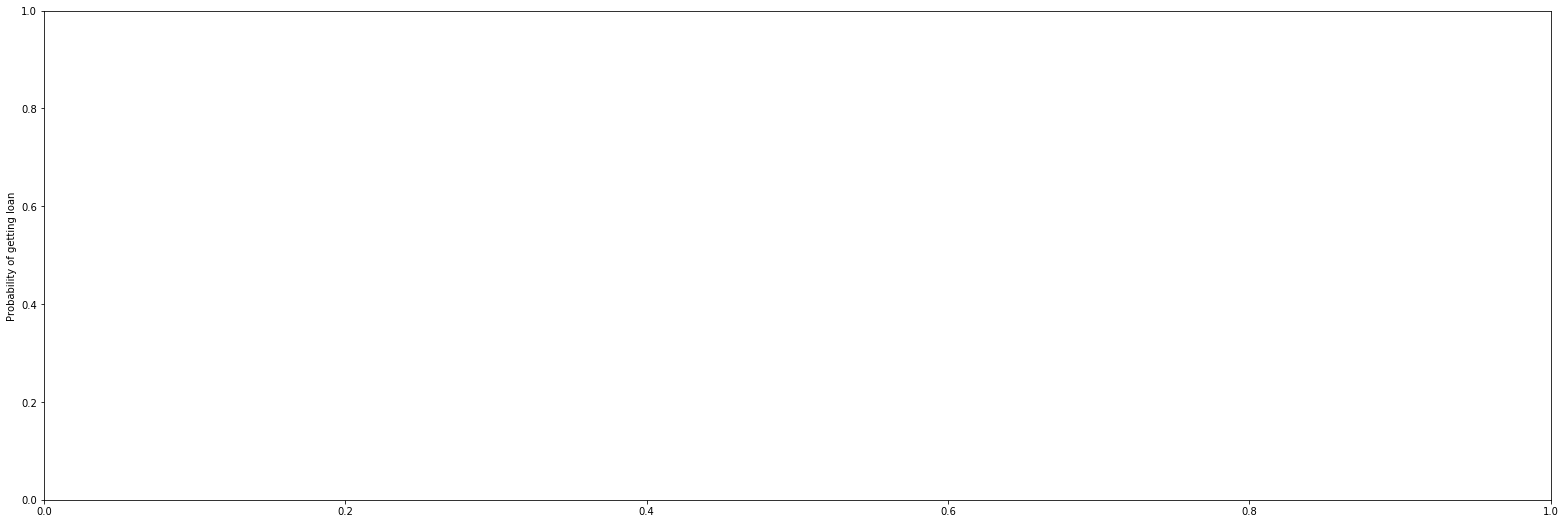

In [123]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(27,9))

temp = data_df.pivot_table(values=['tweet_count'],index=['gender'])
ax = fig.add_subplot(1,1,1) # 1x2 grid on the first subplot
#ax.set_xlabel(feature)
#ax.set_ylabel('Probability of getting loan')
#ax.set_title("Probability by %s" % feature)
temp.plot(kind='bar',ax=ax)

In [175]:
# data_df.pivot_table(values='gender',index=['tweet_count'])

In [103]:
data_df[data_df['_golden'].apply(lambda x : (x==False) )].shape
#pd.DataFrame(data=data_df['_golden'] )

(12858, 26)

In [173]:
def clean(data, categories):
    '''
    Returns cleaned and normalized documents as shown in class.
    '''
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    cleaned_train_with_category = []
    for doc, target in zip(data, categories):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch if ch not in exclude else ' ' for ch in stop_free)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        cleaned_train_with_category.append((normalized.split(),target))
    return cleaned_train_with_category

def count_terms_in_categories(cleaned_train_with_category, categories):
    '''
    for every category, counts the number of times each term has been used,
    uses a dictionary of category-dictionaries
    '''
    # an array with the size of the number of dictionaries, 
    # each dictionary holds a dictionary that maps every term to the number of times it is used
    categories_dictionaries = {}
    # initialize all categories
    for category in categories:
        categories_dictionaries[category] = {}
    for (terms, category) in cleaned_train_with_category:
        for term in terms:
            if term in categories_dictionaries[category]:
                categories_dictionaries[category][term] = categories_dictionaries[category][term] + 1
            else:
                categories_dictionaries[category][term] = 1
    return categories_dictionaries

def order_asc(categories_dictionaries):
    '''
    Using heaps, stores for each category its 10 most used terms
    '''
    top_10_terms = {}
    for category, terms in categories_dictionaries.iteritems():
        heap = [(-value, key) for key,value in terms.items()]
        largest = heapq.nsmallest(10, heap)
        largest = [key for value, key in largest] #[(key, -value) for value, key in largest]
        top_10_terms[category] = largest
    return top_10_terms

In [183]:
cleaned = clean(text_list, gender_list)
terms_with_categories = count_terms_in_categories(cleaned, gender_list)

sorted(terms_with_categories['female'].items(), key = operator.itemgetter(1),reverse=True)
sorted(terms_with_categories['male'].items(), key = operator.itemgetter(1),reverse=True)

[('t', 2321),
 ('co', 2123),
 ('http', 2108),
 ('i', 837),
 ('m', 560),
 ('s', 540),
 ('like', 457),
 ('ù÷', 454),
 ('ù÷â', 390),
 ('get', 378),
 ('one', 362),
 ('day', 362),
 ('love', 348),
 ('go', 305),
 ('make', 300),
 ('time', 287),
 ('people', 249),
 ('want', 225),
 ('know', 222),
 ('u', 221),
 ('new', 208),
 ('amp', 203),
 ('best', 193),
 ('got', 190),
 ('ù', 186),
 ('last', 181),
 ('thing', 180),
 ('need', 174),
 ('back', 172),
 ('can', 170),
 ('good', 169),
 ('see', 164),
 ('ve', 164),
 ('2', 163),
 ('still', 160),
 ('you', 152),
 ('life', 148),
 ('year', 146),
 ('think', 146),
 ('today', 146),
 ('me', 145),
 ('girl', 142),
 ('say', 141),
 ('it', 141),
 ('look', 139),
 ('work', 135),
 ('right', 134),
 ('going', 134),
 ('really', 132),
 ('even', 131),
 ('come', 131),
 ('would', 130),
 ('that', 129),
 ('lol', 128),
 ('friend', 124),
 ('ù\x8f', 121),
 ('take', 120),
 ('much', 119),
 ('always', 118),
 ('way', 117),
 ('never', 116),
 ('feel', 116),
 ('ever', 115),
 ('im', 113),
 ('s